In [3]:
from typing import Callable

from channels.binary_symmetric_channel import BinarySymmetricChannel
from ldpc import LDPC, InputType
from utils.ldpc_utils import create_parity_check_matrix, probs
import numpy as np
from utils.graph_utils import girth_average, create_tanner_graph, girth_average_log
from ldpc import InputType

In [4]:
import networkx as nx
from typing import Callable

def choose_from_random_by_girth_metric(
        girth_metric: Callable[[nx.Graph], float],
        nr_of_matrices: int,
        n: int,
        w_r: int,
        w_c: int) -> (np.ndarray, float, list[float]):
    
    best = (None, 0)
    girths = []
    
    for i in range(nr_of_matrices):
        H = create_parity_check_matrix(n, w_r, w_c)
        if H is not None:
            g = girth_metric(create_tanner_graph(H))
            girths.append(g)    
            
            if g > best[1]:
                best = H, g
    
    return best[0], best[1], girths

In [5]:
def run_binary_channel_simulation(code: LDPC, f: float, nr_of_transmissions: int, bp_iterations: int) -> (float, float):
    bsc = BinarySymmetricChannel(f)
    bit_error_rates = []
    convergence_list = []
    for i in range(nr_of_transmissions):
        print(i)
        x = np.random.randint(0, 2, code.generator_matrix.shape[1])
        y = code.encode(x)
        y_noisy = bsc.transmit(y)
        

        converged, y_dec = code.bp_tan_decode(y_noisy, f, 500)
  
                
        if converged:
            bit_error_rates.append(len(np.where(y != y_dec)[0])/len(y))
            convergence_list.append(True)
        else:
            convergence_list.append(False)
    
    convergence_rate = sum(convergence_list)/len(convergence_list)
    error_rate = 0 if len(bit_error_rates) == 0 else sum(bit_error_rates)/len(bit_error_rates)
    
    return convergence_rate, error_rate 

In [6]:
def test_girth_metric_binary_symmetric(
        girth_metric: Callable[[nx.Graph], float],
        nr_of_matrices: int,
        n: int,
        w_r: int,
        w_c: int,
        nr_of_transmissions: int,
        bp_iterations: int,
        flip_rates) -> (list[float], list[float]):
    
    
    H, g, girths = choose_from_random_by_girth_metric(girth_metric, nr_of_matrices, n, w_r, w_c)
    
    code = LDPC(H)
    
    convergence_rates = []
    bit_error_rates = []
    
    for f in flip_rates:
        
        c_rate, e_rate = run_binary_channel_simulation(
            code,
            f,
            nr_of_transmissions,
            bp_iterations
        )
        
        convergence_rates.append(c_rate)
        bit_error_rates.append(e_rate)
    return convergence_rates, bit_error_rates    


In [12]:
c, e = test_girth_metric_binary_symmetric(
    girth_metric=girth_average, 
    nr_of_matrices=100, 
    n=200, 
    w_r=3, 
    w_c=2, 
    nr_of_transmissions=100, 
    bp_iterations=500, 
    flip_rates=[0.1,0.3,0.5])

0
1
2
3
4


KeyboardInterrupt: 

In [8]:
c, e

([0.8, 0.0, 0.0], [0.0, 0, 0])

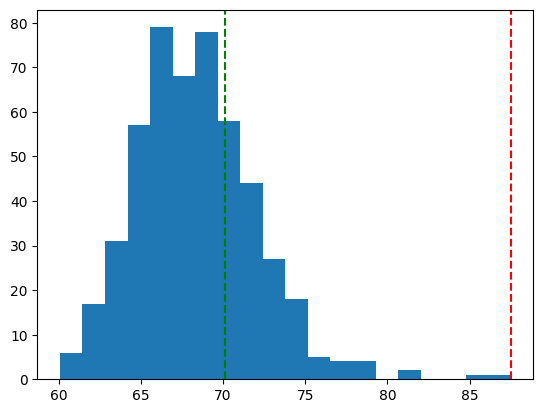

In [33]:
# add a marker for currently_best_H[1] and girht_random to the above plot
plt.hist(girths, bins=20)
plt.axvline(x=best[1], color='r', linestyle='--')
plt.axvline(x=girth_random, color='g', linestyle='--')
plt.show()

NameError: name 'error_rate' is not defined

In [24]:
import sys
from time import sleep

error_rates_best = []
convergence_rates_best = []

error_rates_random = []
convergence_rates_random = []

codes = {
    "best": (LDPC(currently_best_H[0]), error_rates_best, convergence_rates_best),
    "random": (LDPC(H_random), error_rates_random, convergence_rates_random)
}

s = codes["best"][0].generator_matrix.shape[1]
flip_rates = [i/100 for i in range(1,10,2)]
nr_of_transmissions = 100

for f in flip_rates:
    
    sys.stdout.write(f"\r{f}")
    sys.stdout.flush()
    sleep(1)
    
    bsc = BinarySymmetricChannel(f)

    for code_name, (code, error_rates, convergence_rates) in codes.items():
        bit_error_rates = []
        convergence_list = []
        for i in range(nr_of_transmissions):
            
            if i%10 == 0:
                print(i)
            
            x = np.random.randint(0, 2, s)
            y = code.encode(x)
            y_noisy = bsc.transmit(y)
            
            try:
                converged, y_dec = code.bp_tan_decode(y_noisy, f, 500, input_type=InputType.BINARY)
            except Exception as e:
                print(e)
            
            if converged:
                bit_error_rates.append(len(np.where(y != y_dec)[0])/len(y))
                convergence_list.append(True)
            else:
                convergence_list.append(False)
        
        convergence_rates.append(sum(convergence_list)/len(convergence_list))
        error_rates.append(0 if len(bit_error_rates) == 0 else sum(bit_error_rates)/len(bit_error_rates))

0.010
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0.030
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0.050
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0.070
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0.090
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


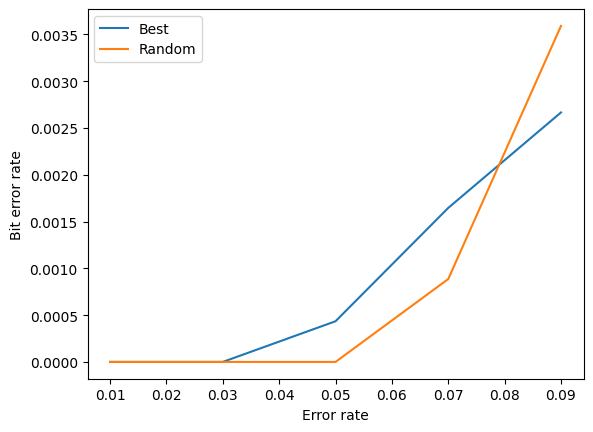

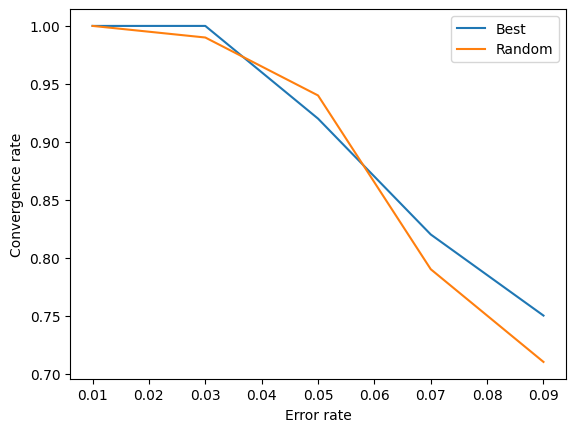

In [25]:
# now create two plots, one for error rates and one for convergence rates
import matplotlib.pyplot as plt
plt.plot(flip_rates, error_rates_best, label="Best")
plt.plot(flip_rates, error_rates_random, label="Random")
plt.xlabel("Error rate")
plt.ylabel("Bit error rate")
plt.legend()
plt.show()

plt.plot(flip_rates, convergence_rates_best, label="Best")
plt.plot(flip_rates, convergence_rates_random, label="Random")
plt.xlabel("Error rate")
plt.ylabel("Convergence rate")
plt.legend()
plt.show()


In [34]:
H_ex = create_parity_check_matrix(7, 3, 2)

In [35]:
H_ex

array([[1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 0, 0, 1, 1]])

In [36]:
c = LDPC(H_ex)

In [37]:
c.generator_matrix

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.],
       [1., 1., 0.]])

In [38]:
c.parity_check_matrix

array([[0, 0, 0, 1, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 0]])

In [39]:
g = create_tanner_graph(c.parity_check_matrix)

created tanner graph


In [41]:
g.nodes

NodeView(('0_0', '1_0', '2_0', '3_0', '0_1', '1_1', '2_1', '3_1', '4_1', '5_1', '6_1'))

In [42]:
import networkx as nx

In [43]:
set_0 = [node for node in g.nodes if node.endswith('_0')]
set_1 = [node for node in g.nodes if node.endswith('_1')]

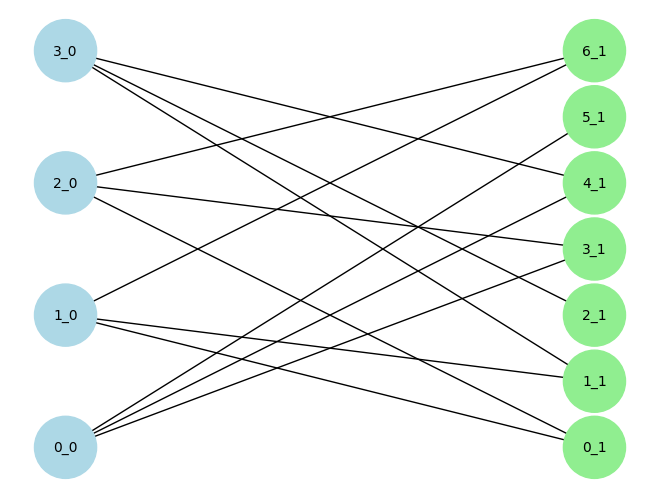

In [45]:
pos = nx.bipartite_layout(g, set_0)
    

nx.draw(g, pos, with_labels=True, node_color=['lightblue' if node in set_0 else 'lightgreen' for node in g.nodes()], node_size=2000, font_size=10)
    

plt.show()